##### OBJETIVO: Procesamiento de variable de MERRA-2 correspondiente a la Composicion de los aerosoles
- https://medium.com/@xhl272703370/tutorial-on-how-to-download-multiple-earthdata-urls-78c96df4c1c7 
- wget --load-cookies ./.urs_cookies --save-cookies ./.urs_cookies --keep-session-cookies --user=josefina88 --ask-password --content-disposition -i subset_M2T1NXAER_5.12.4_20240820_105646_.txt


In [10]:
import os
import pandas as pd
import xarray as xr
import rioxarray
import rasterio
from functools import reduce
import matplotlib.pyplot as plt
import netCDF4
print("librerias ok")

librerias ok


In [12]:
# Datos iniciales 
year = 2015
numRaster = "01"
estacion = "CH"


In [7]:
# Abrir archivo dataset con las coordenadas 
stations = pd.read_csv(
    f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/dataset/estaciones/sitios_{estacion}.csv"
)

stations = stations[
    (stations["Considerado"] == "SI") &
    (stations["tipo"] == "referencia")
].copy()
print("Cantidad de estaciones: ",len(stations))
print(stations)


Cantidad de estaciones:  12
    ID estacion        lat       long Considerado        tipo  ID_archivo  \
0    1      BSQ -33.546067 -70.665171          SI  referencia           0   
1    2      CNA -33.433011 -70.732100          SI  referencia           0   
2    3      FLD -33.516109 -70.588138          SI  referencia           0   
3    4      CDE -33.376392 -70.523462          SI  referencia           0   
4    5      PDH -33.437985 -70.750388          SI  referencia           0   
5    6      PTA -33.591347 -70.594751          SI  referencia           0   
6    7    QUI-I -33.365763 -70.748228          SI  referencia           0   
7    8      OHG -33.464158 -70.660829          SI  referencia           0   
8    9      QUI -33.349623 -70.723827          SI  referencia           0   
9   10      IND -33.422214 -70.651175          SI  referencia           0   
10  11    CER-I -33.492924 -70.719574          SI  referencia           0   
11  12   CER-II -33.495457 -70.704533          S

<xarray.DataArray (y: 33, x: 32)> Size: 4kB
[1056 values with dtype=float32]
Coordinates:
  * y            (y) float64 264B -33.33 -33.34 -33.34 ... -33.58 -33.59 -33.59
  * x            (x) float64 256B -70.82 -70.81 -70.8 ... -70.53 -70.52 -70.51
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  0.56723296642303
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  0.12767471373081
    STATISTICS_STDDEV:   -9999
    _FillValue:          -3.4e+38
    scale_factor:        1.0
    add_offset:          0.0


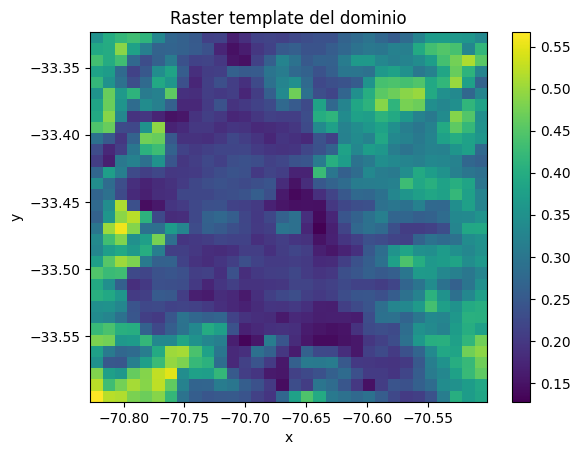

In [ ]:
# Template del dominio determinado por MAIAC
template = rioxarray.open_rasterio(
    f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/dataset/rasterTemplate/{numRaster}_raster_template.tif"
).squeeze()


print(template)

#Plot del dominio
template.plot()
plt.title("Raster template del dominio")
plt.show()

In [ ]:
# Archivos de MERRA-2
base_dir = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/dataset/04_MERRA-2_Dia/{year}"

# files = [f for f in os.listdir(base_dir) if f.endswith(".nc")]

files = []
for f in os.listdir(base_dir):
    if f.endswith(".nc"):
        files.append(f)
print(files)


['MERRA2_400.tavg1_2d_aer_Nx.20150101.SUB.nc', 'MERRA2_400.tavg1_2d_aer_Nx.20150102.SUB.nc', 'MERRA2_400.tavg1_2d_aer_Nx.20150103.SUB.nc']


In [ ]:
#Extraccion de variables en cada una de los archivos
variables = [
    "BCSMASS", "DUSMASS", "DUSMASS25",
    "OCSMASS", "SO2SMASS", "SO4SMASS",
    "SSSMASS", "SSSMASS25"
]

rows = []

for i, nc_file in enumerate(files, start=1):
    print(i, nc_file)

    ds = xr.open_dataset(os.path.join(base_dir, nc_file), engine="netcdf4")

    # fecha desde el nombre (ajustar si cambia)
    date = nc_file[27:35]

    # Vamos obtniendo dato segun variable
    for var in variables:
        if var not in ds:
            continue

        da = ds[var]
        unit = da.attrs.get("units", "")

        # reproyección + resample
        da = da.rio.write_crs("EPSG:4326", inplace=True)
        da = da.rio.reproject_match(template)

        for _, st in stations.iterrows():
            value = da.sel(
                x=st["long"],
                y=st["lat"],
                method="nearest"
            ).values.item()

            rows.append({
                "date": date,
                "variable": var,
                "unidad": unit,
                "value": value,
                "estacion": st["estacion"],
                "ID": st["ID"]
            })
df_all = pd.DataFrame(rows)
df_all

1 MERRA2_400.tavg1_2d_aer_Nx.20150101.SUB.nc
2 MERRA2_400.tavg1_2d_aer_Nx.20150102.SUB.nc
3 MERRA2_400.tavg1_2d_aer_Nx.20150103.SUB.nc


,date,variable,unidad,value,estacion,ID
0,20150101,BCSMASS,kg m-3,6.121045e-10,BSQ,1
1,20150101,BCSMASS,kg m-3,6.121045e-10,CNA,2
2,20150101,BCSMASS,kg m-3,6.121045e-10,FLD,3
3,20150101,BCSMASS,kg m-3,6.121045e-10,CDE,4
4,20150101,BCSMASS,kg m-3,6.121045e-10,PDH,5
...,...,...,...,...,...,...
283,20150103,SSSMASS25,kg m-3,1.373479e-09,OHG,8
284,20150103,SSSMASS25,kg m-3,1.373479e-09,QUI,9
285,20150103,SSSMASS25,kg m-3,1.373479e-09,IND,10
286,20150103,SSSMASS25,kg m-3,1.373479e-09,CER-I,11


In [23]:
# Funcion para separar por variable
def split_var(df, var):
    sub = df[df["variable"] == var].copy()
    return sub[["date", "estacion", "ID", "value", "unidad"]].rename(
        columns={
            "value": var,
            "unidad": f"unidad_{var}"
        }
    )

dfs = [split_var(df_all, v) for v in variables]
print(dfs)

[         date estacion  ID       BCSMASS unidad_BCSMASS
0    20150101      BSQ   1  6.121045e-10         kg m-3
1    20150101      CNA   2  6.121045e-10         kg m-3
2    20150101      FLD   3  6.121045e-10         kg m-3
3    20150101      CDE   4  6.121045e-10         kg m-3
4    20150101      PDH   5  6.121045e-10         kg m-3
5    20150101      PTA   6  6.121045e-10         kg m-3
6    20150101    QUI-I   7  6.121045e-10         kg m-3
7    20150101      OHG   8  6.121045e-10         kg m-3
8    20150101      QUI   9  6.121045e-10         kg m-3
9    20150101      IND  10  6.121045e-10         kg m-3
10   20150101    CER-I  11  6.121045e-10         kg m-3
11   20150101   CER-II  12  6.121045e-10         kg m-3
96   20150102      BSQ   1  7.465922e-10         kg m-3
97   20150102      CNA   2  7.465922e-10         kg m-3
98   20150102      FLD   3  7.465922e-10         kg m-3
99   20150102      CDE   4  7.465922e-10         kg m-3
100  20150102      PDH   5  7.465922e-10       

In [24]:
# Merge total
merged_df = reduce(
    lambda x, y: pd.merge(x, y, on=["ID", "date", "estacion"], how="outer"),
    dfs
)
print(merged_df)


        date estacion  ID       BCSMASS unidad_BCSMASS       DUSMASS  \
0   20150101      BSQ   1  6.121045e-10         kg m-3  7.840134e-10   
1   20150102      BSQ   1  7.465922e-10         kg m-3  2.020831e-09   
2   20150103      BSQ   1  1.022410e-09         kg m-3  2.685169e-09   
3   20150101      CNA   2  6.121045e-10         kg m-3  7.840134e-10   
4   20150102      CNA   2  7.465922e-10         kg m-3  2.020831e-09   
5   20150103      CNA   2  1.022410e-09         kg m-3  2.685169e-09   
6   20150101      FLD   3  6.121045e-10         kg m-3  7.840134e-10   
7   20150102      FLD   3  7.465922e-10         kg m-3  2.020831e-09   
8   20150103      FLD   3  1.022410e-09         kg m-3  2.685169e-09   
9   20150101      CDE   4  6.121045e-10         kg m-3  7.840134e-10   
10  20150102      CDE   4  7.465922e-10         kg m-3  2.020831e-09   
11  20150103      CDE   4  1.022410e-09         kg m-3  2.685169e-09   
12  20150101      PDH   5  6.121045e-10         kg m-3  7.840134

In [ ]:
# Guardar datos en formato csv para usarlo
# Cada carpeta tiene los datos de un año
out = (
    f"D:/Josefina/Proyectos/ProyectoChile/{estacion}"
    f"/proceed/04_MERRA-2_Dia/MERRA-2_Dia_11-12_{year}.csv"
)

merged_df.to_csv(out, index=False)

